# Deep learning solution method with all-in-one expectation operator for RBC

In [28]:
import tensorflow as tf
import numpy as np
from math import sqrt, exp, log
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

We want to extract our model with dolo.

In [29]:
from dolo import *
import dolo.compiler.factories as f

In [30]:
model = yaml_import('rbc.yaml')

We must now extract the information we need from this model structure and adapt it to our DL problem.

In [31]:
ff = f.get_factory(model, eq_type = 'auxiliary')
ff

FlatFunctionFactory(preamble={'y__0_': '((exp(z__0_))*((k__0_)^(alpha_)))*((n__0_)^(1 - (alpha_)))', 'c__0_': 'y__0_ - (i__0_)', 'rk__0_': '((alpha_)*(y__0_))/(k__0_)', 'w__0_': '((1 - (alpha_))*(y__0_))/(n__0_)'}, content={'out0__0_': 'y__0_', 'out1__0_': 'c__0_', 'out2__0_': 'rk__0_', 'out3__0_': 'w__0_'}, arguments={'m': ['e_z__0_'], 's': ['z__0_', 'k__0_'], 'x': ['n__0_', 'i__0_'], 'p': ['beta_', 'sigma_', 'eta_', 'chi_', 'delta_', 'alpha_', 'rho_', 'zbar_', 'sig_z_']}, funname='auxiliary')

I do not know yet how to take this FlatFunctionFactory and extract the information I want. For the time being, I will write everything down manually but latter I would like to make this step automatic. 

In [32]:
# Model parameters

β = 0.99
σ = 5
η = 1
δ = 0.025
α = 0.33
ρ = 0.8          
σ_z = 0.016
kss = 10
n = 0.33
zbar = 0

z = zbar
rk = 1/β-1+δ
k = n/(rk/α)**(1/(1-α))
w = (1-α)*exp(z)*(k/n)**(α)
y = exp(z)*(k**α)*(n**(1-α))
i = δ*k
c = y - i
ꭓ = w/c**σ/n**η
V = log(c)/(1-β)
u = c**(1-σ)/(1-σ) - ꭓ*n**(1+η)/(1+η)
m = β/(c**σ)*(1-δ+rk)

In [33]:
# Standard deviation for ergodic distribution of endogenous state variable z
σ_e_z = σ_z/(1-ρ**2)**0.5

# bounds for endogenous state variables z and k
zmin = -2*σ_e_z
zmax = 2*σ_e_z
kmin = kss*0.5
kmax = kss*1.5

In [55]:
# construction of neural network number 1 that gives c
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
]
perceptron_c = tf.keras.Sequential(layers)

# construction of neural network number 2 that gives i
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
]
perceptron_i = tf.keras.Sequential(layers)

In [56]:
# this cell requires graphviz (replace by UML plot)
#tf.keras.utils.plot_model(perceptron_c, to_file='model.png', show_shapes=True)
#tf.keras.utils.plot_model(perceptron_i, to_file='model.png', show_shapes=True)

In [57]:
def dr(z: Vector, k: Vector)-> Tuple[Vector]:            # dr = decision rule   

    # we normalize endogenous state variable z by its 2 standard deviation
    # so that it is typically between -1 and 1 
    z = z/σ_e_z/2

    # we normalize endogenous state variable k between -1 and 1
    k = (k-kmin)/(kmax-kmin)*2.0-1.0

    # we prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in [z,k]], axis=1) # equivalent to np.column_stack

    x_1 = perceptron_c(s) # n x 1 matrix
    x_2 = perceptron_i(s) # n x 1 matrix
    
    # We apply exp because this ensures that c and i are always positive
    c = tf.exp(x_1[:,0])
    i = tf.exp(x_2[:,0])
    
    return (c,i)

In [58]:
zvec = np.linspace(zmin, zmax, 100)
kvec = np.linspace(kmin, kmax, 100)

(cvec,ivec) = dr(zvec,kvec)
a = tf.exp(zvec)
a = tf.cast(a, tf.float32)
b = kvec**α
b = tf.cast(b, tf.float32)
nvec = ((cvec+ivec)/(a*b))**(1/(1-α))

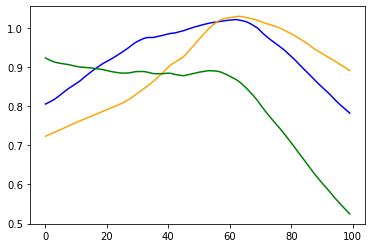

In [59]:
plt.plot(cvec,color='blue')
plt.plot(ivec,color='orange')
plt.plot(nvec,color='green')         # Just to check that there is no issue until now

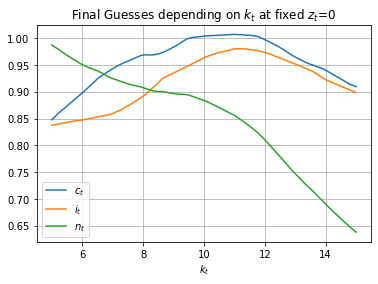

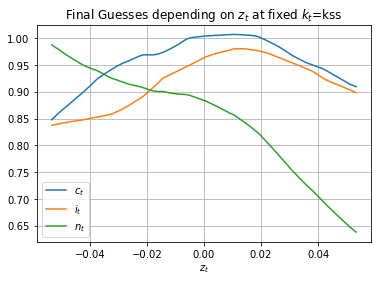

In [60]:
cmat = []
imat = []
nmat = []

for z in zvec :
    zvec_const = z*kvec/kvec
    (cvec,ivec) = dr(zvec_const,kvec)
    a = tf.exp(zvec_const)
    a = tf.cast(a, tf.float32)
    b = kvec**α
    b = tf.cast(b, tf.float32)
    nvec = ((cvec+ivec)/(a*b))**(1/(1-α))
    cmat.append(cvec.numpy())
    imat.append(ivec.numpy())
    nmat.append(nvec.numpy())

cmat = np.asarray(cmat)
imat = np.asarray(imat)
nmat = np.asarray(nmat)

plt.figure(1)
#plt.plot(kvec, kvec, linestyle='--', color='black')
plt.plot(kvec,cmat[49],label = '$c_t$')
plt.plot(kvec,imat[49],label = '$i_t$')
plt.plot(kvec,nmat[49],label = '$n_t$')
plt.xlabel("$k_t$")
plt.title("Final Guesses depending on $k_t$ at fixed $z_t$=0")
plt.legend()
plt.grid()

plt.figure(2)
#plt.plot(zvec, zvec, linestyle='--', color='black')
plt.plot(zvec,cmat[:][49],label = '$c_t$')
plt.plot(zvec,imat[:][49],label = '$i_t$')
plt.plot(zvec,nmat[:][49],label = '$n_t$')
plt.xlabel("$z_t$")
plt.title("Final Guesses depending on $z_t$ at fixed $k_t$=kss")
plt.legend()
plt.grid()

In [61]:
def Residuals(e_z: Vector, z: Vector, k: Vector):

    # all inputs are expected to have the same size n
    size = tf.size(z)

    # arguments correspond to the values of the states today
    c,i = dr(z, k)
    y = c + i
    a = tf.exp(z)
    a = tf.cast(a, tf.float32)
    b = k**α
    b = tf.cast(b, tf.float32)
    n = (y/(a*b))**(1/(1-α))
    n = tf.cast(n, tf.float32)
    w = (1-α)*y/n

    # transitions of the exogenous and endogenous processes (next denotes variables at t+1)
    znext = z*ρ + e_z
    knext = (1-δ)*k + i

    cnext,inext = dr(znext, knext)
    ynext = cnext + inext
    rknext = α*ynext/knext

    R1 = β*((c/cnext)**σ)*(1-δ+rknext) - 1
    R2 = ꭓ*(n**η)*(c**σ)/w - 1

    return (R1, R2)

In [62]:
def Ξ(n): # objective function for DL training

    # randomly drawing current states
    k = tf.random.uniform(shape=(n,), minval=kmin, maxval=kmax)
    z = tf.random.normal(shape=(n,), stddev=σ_e_z)
 
    # randomly drawing 1st realization for shocks
    e1_z = tf.random.normal(shape=(n,), stddev=σ_z)

    # randomly drawing 2nd realization for shocks
    e2_z = tf.random.normal(shape=(n,), stddev=σ_z)
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(e1_z, z, k)
    R1_e2, R2_e2 = Residuals(e2_z, z, k)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + R2_e1*R2_e2          # Taille n
    
    # compute average across n random draws
    return tf.reduce_mean(R_squared)

In [63]:
n = 128
v = Ξ(n)
v.numpy()    # Just to see if there is an error and choose n

100.502335

# Model Training

In [64]:
θ_c = perceptron_c.trainable_variables
print( str(θ_c)[:1000] ) # we truncate output

θ_i = perceptron_i.trainable_variables
print( str(θ_i)[:1000] ) # we truncate output

#variables = tf.concat([θ_c , θ_i])

[<tf.Variable 'dense_16/kernel:0' shape=(2, 32) dtype=float32, numpy=
array([[-0.08293575,  0.30607554,  0.24543169, -0.3248796 , -0.37736535,
        -0.01460302, -0.29599714, -0.01667795,  0.3581206 , -0.2749493 ,
         0.08495429, -0.06202641,  0.00487497,  0.3893548 ,  0.08997288,
         0.1522353 ,  0.09896228,  0.2541614 ,  0.04476997,  0.24294308,
        -0.15558869,  0.30771777,  0.05616307,  0.19034085, -0.24112849,
        -0.2985405 , -0.13100073,  0.19939515,  0.27640137,  0.20268837,
         0.09918514, -0.17164437],
       [ 0.22535667,  0.10506758,  0.0311743 , -0.11470196,  0.2249904 ,
         0.05076247,  0.3027666 , -0.30011016,  0.23202083, -0.36886734,
        -0.1087403 ,  0.07589608, -0.25230837,  0.21254829, -0.3779665 ,
         0.2600899 ,  0.19013903,  0.29937008, -0.14835894, -0.02275482,
        -0.25479513,  0.3319688 ,  0.12478474, -0.14760846,  0.25504825,
         0.06004521, -0.08587071, -0.38602373, -0.11069474,  0.2470425 ,
         0.13820753

In [65]:
from tensorflow.keras.optimizers import Adam, SGD     # Choice of otpimizer

In [66]:
optimizer = Adam()
# optimizer = SGD(λ=0.1) # SGD can be used in place of Adam

In [67]:
@tf.function
def training_step_c():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ_c)
    optimizer.apply_gradients(zip(grads,θ_c))

    return xx

In [68]:
@tf.function
def training_step_i():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ_i)
    optimizer.apply_gradients(zip(grads,θ_i))

    return xx

In [69]:
def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):                 # Ici je réalise une optimisation des paramètres de chaque réseaux de neuronne de 
        val_1 = training_step_c()               # manière imbriquée : j'améliore le réseau pour la consommation puis celui pour l'investissement
        vals.append(val_1.numpy())              # puis je boucle. Malheureusement ça veut dire que que je ne calcul qu'un gradient partiel d'un 
                                                # certain nombre des paramètres puis des autres.
        val_2 = training_step_i()               
        vals.append(val_2.numpy())
        
    return vals

In [70]:
# with writer.as_default():
results = train_me(50000)

100%|██████████| 50000/50000 [01:30<00:00, 554.93it/s]


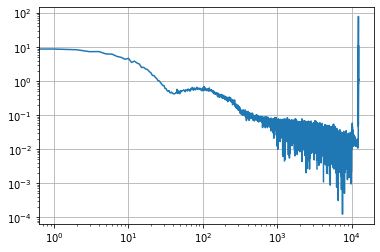

In [71]:
plt.plot(np.sqrt(results))
plt.xscale('log')
plt.yscale('log')
plt.grid()

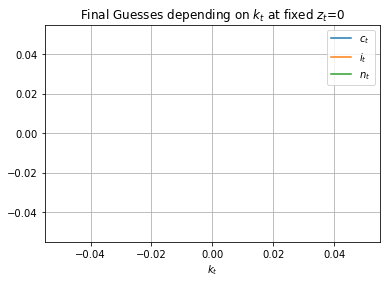

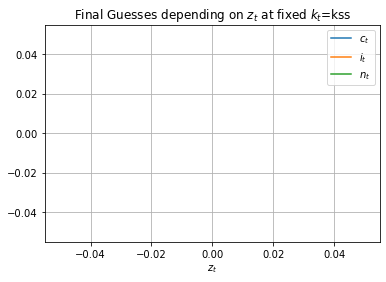

In [72]:
zvec = np.linspace(zmin, zmax, 100)
kvec = np.linspace(kmin, kmax, 100)

cmat = []
imat = []
nmat = []

for z in zvec :
    zvec_const = z*kvec/kvec
    cvec,ivec = dr(zvec_const,kvec)
    a = tf.exp(zvec_const)
    a = tf.cast(a, tf.float32)
    b = kvec**α
    b = tf.cast(b, tf.float32)
    nvec = ((cvec+ivec)/(a*b))**(1/(1-α))
    cmat.append(cvec.numpy())
    imat.append(ivec.numpy())
    nmat.append(nvec.numpy())

cmat = np.asarray(cmat)
imat = np.asarray(imat)
nmat = np.asarray(nmat)

plt.figure(1)
#plt.plot(kvec, kvec, linestyle='--', color='black')
plt.plot(kvec,cmat[49],label = '$c_t$')
plt.plot(kvec,imat[49],label = '$i_t$')
plt.plot(kvec,nmat[49],label = '$n_t$')
plt.xlabel("$k_t$")
plt.title("Final Guesses depending on $k_t$ at fixed $z_t$=0")
plt.legend()
plt.grid()

plt.figure(2)
#plt.plot(zvec, zvec, linestyle='--', color='black')
plt.plot(zvec,cmat[:][49],label = '$c_t$')
plt.plot(zvec,imat[:][49],label = '$i_t$')
plt.plot(zvec,nmat[:][49],label = '$n_t$')
plt.xlabel("$z_t$")
plt.title("Final Guesses depending on $z_t$ at fixed $k_t$=kss")
plt.legend()
plt.grid()

    Z contains NaN values. This may result in rendering artifacts.


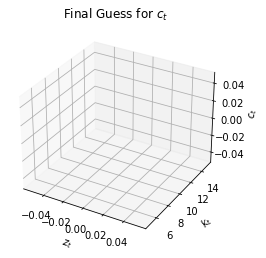

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(zvec, kvec)

ax.plot_surface(X, Y, cmat)

ax.set_xlabel('$z_t$')
ax.set_ylabel('$k_t$')
ax.set_zlabel('$c_t$')

plt.title('Final Guess for $c_t$')
plt.show()

    Z contains NaN values. This may result in rendering artifacts.


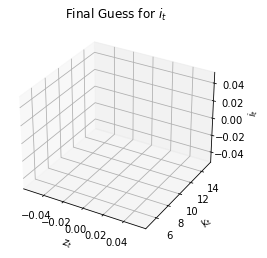

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(zvec, kvec)

ax.plot_surface(X, Y, imat)

ax.set_xlabel('$z_t$')
ax.set_ylabel('$k_t$')
ax.set_zlabel('$i_t$')

plt.title('Final Guess for $i_t$')
plt.show()

    Z contains NaN values. This may result in rendering artifacts.


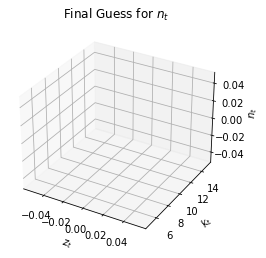

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(zvec, kvec)

ax.plot_surface(X, Y, nmat)

ax.set_xlabel('$z_t$')
ax.set_ylabel('$k_t$')
ax.set_zlabel('$n_t$')

plt.title('Final Guess for $n_t$')
plt.show()